In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm, tqdm_notebook
from collections import defaultdict
from google.colab import files
#uploaded = files.upload()

In [2]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [0]:
from google.cloud import bigquery
# TODO: Uncomment the line below to set the `project` variable.
project_id = 'mimiciii-database'
#
# The `project` variable defines the project to be billed for query
# processing. The user must have the bigquery.jobs.create permission on
# this project to run a query. See:
# https://cloud.google.com/bigquery/docs/access-control#permissions
client = bigquery.Client(project=project_id)
sql = """
    SELECT *
    FROM `mimiciii-database.MIMIC3_V1_4.ADMISSIONS`
    LIMIT 100
"""

# Run a Standard SQL query using the environment's default project
#df = client.query(sql).to_dataframe()""

# Run a Standard SQL query with the project set explicitly
project_id = 'mimiciii-database'
df = client.query(sql, project=project_id).to_dataframe()
df

In [0]:
# Filter icu admissions, db = metavision (2008-2012)
query4_2 = """
WITH adult_adm AS
( SELECT DISTINCT subject_id
  FROM `mimiciii-database.MIMIC3_V1_4.ADMISSIONS`
  WHERE admission_type != 'NEWBORN')
,
icu_mort AS
(
SELECT p.subject_id, i.hadm_id, i.icustay_id, i.intime, i.outtime, i.LOS, p.dod, dod_hosp, p.expire_flag,i.dbsource,
CASE 
  WHEN DATETIME(dod) BETWEEN intime AND outtime
    THEN 1
  WHEN DATETIME_DIFF(DATETIME(dod), outtime, HOUR) <= 24
    THEN 1
    ELSE 0
    END AS in_hospital_mortality
FROM `mimiciii-database.MIMIC3_V1_4.PATIENTS` p
JOIN `mimiciii-database.MIMIC3_V1_4.ICUSTAYS` i
ON p.subject_id = i.subject_id
    )
SELECT a.subject_id, im.hadm_id, im.icustay_id, im.intime, im.outtime, im.LOS, im.dod, im.dod_hosp, im.expire_flag,im.in_hospital_mortality
FROM adult_adm AS a
JOIN icu_mort AS im
ON a.subject_id = im.subject_id
WHERE im.LOS > 1  AND im.dbsource = 'metavision'
-- AND im.in_hospital_mortality = 1
"""
# ICU stay > 24hrs
#19705 ICU stays in total; 1623 in-hospital mortality. 8.23% mortality rate

In [0]:
df = client.query(query4_2, project=project_id).to_dataframe()


In [0]:
# In-hospital mortality
df_mort = df[df['in_hospital_mortality']==1]
df_non_mort = df[df['in_hospital_mortality']==0]
df_mort.describe()

# 1623 of 19705 ICU stays died during ICU admission. 
# The average length of stay is 6.84 days.

,subject_id,hadm_id,icustay_id,LOS,expire_flag,in_hospital_mortality
count,1623.000000,1623.000000,1623.000000,1623.000000,1623.0,1623.0
mean,61563.810844,150205.020333,250261.836106,6.849687,1.0,1.0
std,23838.825116,28735.613808,29004.122623,7.694193,0.0,0.0
min,109.000000,100061.000000,200033.000000,1.002500,1.0,1.0
25%,46762.000000,125408.000000,224919.000000,2.135850,1.0,1.0
50%,62835.000000,150503.000000,250736.000000,4.218300,1.0,1.0
75%,80958.000000,175205.000000,276087.500000,8.325850,1.0,1.0
max,99955.000000,199949.000000,299889.000000,67.973500,1.0,1.0


In [0]:
# The average length of stay for survivors is 3.91 days.
df_non_mort.describe()

,subject_id,hadm_id,icustay_id,LOS,expire_flag,in_hospital_mortality
count,18082.000000,18082.000000,18082.000000,18082.000000,18082.000000,18082.0
mean,62646.554087,150143.371917,250219.622387,3.913580,0.285698,0.0
std,24099.781569,28851.074371,28846.851159,4.916774,0.451759,0.0
min,23.000000,100001.000000,200001.000000,1.000100,0.000000,0.0
25%,47481.500000,125067.250000,225335.250000,1.487175,0.000000,0.0
50%,64544.000000,150282.000000,250485.500000,2.243600,0.000000,0.0
75%,82210.500000,175026.750000,274990.250000,4.100600,1.000000,0.0
max,99999.000000,199999.000000,299998.000000,101.739000,1.000000,0.0


(array([1.3969e+04, 2.1140e+03, 8.7800e+02, 4.3400e+02, 2.5200e+02,
        1.4200e+02, 9.4000e+01, 6.1000e+01, 4.2000e+01, 2.7000e+01,
        2.2000e+01, 1.1000e+01, 9.0000e+00, 1.0000e+01, 4.0000e+00,
        1.0000e+00, 1.0000e+00, 5.0000e+00, 3.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1.0001    ,   4.35806333,   7.71602667,  11.07399   ,
         14.43195333,  17.78991667,  21.14788   ,  24.50584333,
         27.86380667,  31.22177   ,  34.57973333,  37.93769667,
         41.29566   ,  44.65362333,  48.01158667,  51.36955   ,
         54.72751333,  58.08547667,  61.44344   ,  64.80140333,
         68.15936667,  71.51733   ,  74.87529333,  78.23325667,
         81.59122   ,  84.94918333,  88.30714667,  91.66511   ,
         95.02307333,  98.38103667, 101.739     ]),
 <a list of 30 Patch objects>)

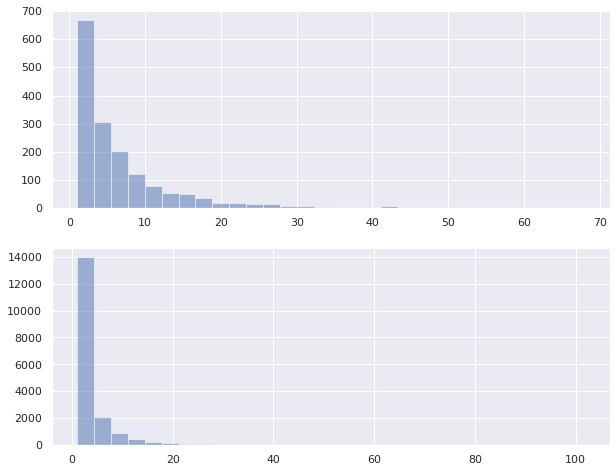

In [0]:
#visualization for hospital length of stay.
los_mort = df_mort['LOS']
los_non_mort = df_non_mort['LOS']
#los_mort
#df_non_mort
fig, ax = plt.subplots(2,figsize=(10,8))
ax[0].hist(los_mort,bins=30,alpha= 0.5)
ax[1].hist(los_non_mort,bins=30,alpha= 0.5)

In [0]:
#Inspect data, distribution stratified by year
query5 = """
WITH vitals AS (
  select ie.subject_id, ie.hadm_id, ie.icustay_id
  , case
    when itemid in (211,220045) and valuenum > 0 and valuenum < 300 then 1 -- HeartRate
    when itemid in (51,442,455,6701,220179,220050) and valuenum > 0 and valuenum < 400 then 2 -- SysBP
    when itemid in (8368,8440,8441,8555,220180,220051) and valuenum > 0 and valuenum < 300 then 3 -- DiasBP
    when itemid in (456,52,6702,443,220052,220181,225312) and valuenum > 0 and valuenum < 300 then 4 -- MeanBP
    when itemid in (615,618,220210,224690) and valuenum > 0 and valuenum < 70 then 5 -- RespRate
    when itemid in (223761,678) and valuenum > 70 and valuenum < 120  then 6 -- TempF, converted to degC in valuenum call
    when itemid in (223762,676) and valuenum > 10 and valuenum < 50  then 6 -- TempC
    when itemid in (646,220277) and valuenum > 0 and valuenum <= 100 then 7 -- SpO2
    when itemid in (807,811,1529,3745,3744,225664,220621,226537) and valuenum > 0 then 8 -- Glucose

    else null end as VitalID
      -- convert F to C
  , case when itemid in (223761,678) then (valuenum-32)/1.8 else valuenum end as valuenum,
  ce.charttime, FORMAT_DATETIME("%Y",ce.charttime) AS year

  from `mimiciii-database.MIMIC3_V1_4.ICUSTAYS` AS ie
  left join `mimiciii-database.MIMIC3_V1_4.CHARTEVENTS` ce
  on ie.icustay_id = ce.icustay_id
  and ce.charttime between ie.intime and ie.outtime
  and DATETIME_DIFF(ce.charttime, ie.intime, SECOND) > 0
  and DATETIME_DIFF(ce.charttime, ie.outtime, SECOND) < 0
  -- exclude rows marked as error
  and (ce.error IS NULL or ce.error = 0)
  where ce.itemid in
  (
  -- HEART RATE
  211, --"Heart Rate"
  220045, --"Heart Rate"

  -- Systolic/diastolic

  51, --	Arterial BP [Systolic]
  442, --	Manual BP [Systolic]
  455, --	NBP [Systolic]
  6701, --	Arterial BP #2 [Systolic]
  220179, --	Non Invasive Blood Pressure systolic
  220050, --	Arterial Blood Pressure systolic

  8368, --	Arterial BP [Diastolic]
  8440, --	Manual BP [Diastolic]
  8441, --	NBP [Diastolic]
  8555, --	Arterial BP #2 [Diastolic]
  220180, --	Non Invasive Blood Pressure diastolic
  220051, --	Arterial Blood Pressure diastolic


  -- MEAN ARTERIAL PRESSURE
  456, --"NBP Mean"
  52, --"Arterial BP Mean"
  6702, --	Arterial BP Mean #2
  443, --	Manual BP Mean(calc)
  220052, --"Arterial Blood Pressure mean"
  220181, --"Non Invasive Blood Pressure mean"
  225312, --"ART BP mean"

  -- RESPIRATORY RATE
  618,--	Respiratory Rate
  615,--	Resp Rate (Total)
  220210,--	Respiratory Rate
  224690, --	Respiratory Rate (Total)


  -- SPO2, peripheral
  646, 220277,

  -- GLUCOSE, both lab and fingerstick
  807,--	Fingerstick Glucose
  811,--	Glucose (70-105)
  1529,--	Glucose
  3745,--	BloodGlucose
  3744,--	Blood Glucose
  225664,--	Glucose finger stick
  220621,--	Glucose (serum)
  226537,--	Glucose (whole blood)

  -- TEMPERATURE
  223762, -- "Temperature Celsius"
  676,	-- "Temperature C"
  223761, -- "Temperature Fahrenheit"
  678 --	"Temperature F"

  )
  AND ie.dbsource = 'metavision'
 )
SELECT year, VitalID, COUNT(VitalID) AS count
FROM vitals
GROUP BY year, VitalID
ORDER BY year, VitalID
--LIMIT 10000
"""

In [0]:
df = client.query(query5, project=project_id).to_dataframe()
df

,year,VitalID,count
0,2100,NaN,0
1,2100,1.0,10221
2,2100,2.0,10147
3,2100,3.0,10142
4,2100,4.0,10437
...,...,...,...
984,2209,4.0,229
985,2209,5.0,245
986,2209,6.0,66
987,2209,7.0,236


In [0]:
df = df.dropna()
dfp =  df.set_index(['year','VitalID']).unstack()
dfp.colums = ['HR','SBP','DBP','mean_BP','RR','BT','SpO2','Glu']
cols = dfp.colums

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
dfp

count                                               
VitalID    1.0    2.0    3.0    4.0    5.0   6.0    7.0   8.0
year                                                         
2100     10221  10147  10142  10437  10823  2706  10041  2149
2101     16855  17168  17161  17900  17627  4477  16459  3426
2102     19823  19796  19791  20397  21039  5261  19403  3640
2103     18584  18773  18760  19226  19712  4886  18345  3939
2104     22154  22480  22472  23141  24302  6328  21591  4773
...        ...    ...    ...    ...    ...   ...    ...   ...
2205      1464   1489   1488   1494   1546   452   1417   320
2206      1920   1997   1997   2004   2050   527   1904   453
2207      1015   1001   1001   1003   1095   279   1015   191
2208       523    506    506    540    549   193    523    89
2209       241    231    231    229    245    66    236    57

[110 rows x 8 columns]

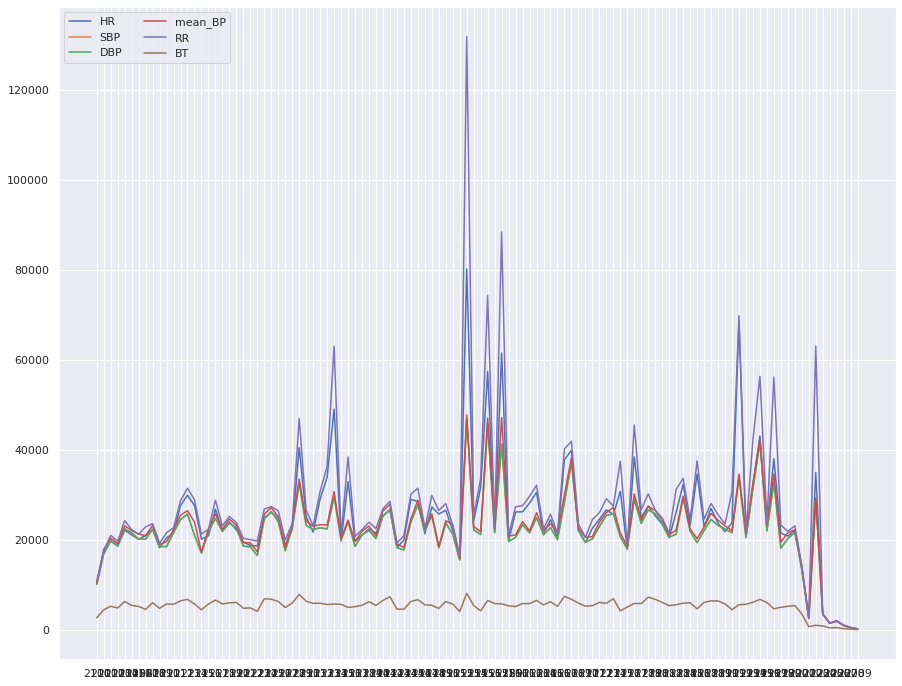

In [0]:
fig, ax = plt.subplots()
fig.set_size_inches(15,12)
for col in range(6):
    plt.plot(dfp.iloc[:,col])

plt.legend(cols,ncol=2, loc='upper left')
#plt.xticks(rotation=90)
# Due to the de-identification process, the admissions were shifted across a hundred year.

In [0]:
#Explore the distribution of timestamps for each variables
query6= """
WITH vitals AS (
  select ie.subject_id, ie.hadm_id, ie.icustay_id
  , case
    when itemid in (211,220045) and valuenum > 0 and valuenum < 300 then 1 -- HeartRate
    when itemid in (51,442,455,6701,220179,220050) and valuenum > 0 and valuenum < 400 then 2 -- SysBP
    when itemid in (8368,8440,8441,8555,220180,220051) and valuenum > 0 and valuenum < 300 then 3 -- DiasBP
    when itemid in (456,52,6702,443,220052,220181,225312) and valuenum > 0 and valuenum < 300 then 4 -- MeanBP
    when itemid in (615,618,220210,224690) and valuenum > 0 and valuenum < 70 then 5 -- RespRate
    when itemid in (223761,678) and valuenum > 70 and valuenum < 120  then 6 -- TempF, converted to degC in valuenum call
    when itemid in (223762,676) and valuenum > 10 and valuenum < 50  then 6 -- TempC
    when itemid in (646,220277) and valuenum > 0 and valuenum <= 100 then 7 -- SpO2
    when itemid in (807,811,1529,3745,3744,225664,220621,226537) and valuenum > 0 then 8 -- Glucose

    else null end as VitalID
      -- convert F to C
  , case when itemid in (223761,678) then (valuenum-32)/1.8 else valuenum end as valuenum,
  ce.charttime, FORMAT_DATETIME("%H:%M",ce.charttime) AS timestamps

  from `mimiciii-database.MIMIC3_V1_4.ICUSTAYS` AS ie
  left join `mimiciii-database.MIMIC3_V1_4.CHARTEVENTS` ce
  on ie.icustay_id = ce.icustay_id
  and ce.charttime between ie.intime and ie.outtime
  and DATETIME_DIFF(ce.charttime, ie.intime, SECOND) > 0
  and DATETIME_DIFF(ce.charttime, ie.outtime, SECOND) < 0
  -- exclude rows marked as error
  and (ce.error IS NULL or ce.error = 0)
  where ce.itemid in
  (
  -- HEART RATE
  211, --"Heart Rate"
  220045, --"Heart Rate"

  -- Systolic/diastolic

  51, --	Arterial BP [Systolic]
  442, --	Manual BP [Systolic]
  455, --	NBP [Systolic]
  6701, --	Arterial BP #2 [Systolic]
  220179, --	Non Invasive Blood Pressure systolic
  220050, --	Arterial Blood Pressure systolic

  8368, --	Arterial BP [Diastolic]
  8440, --	Manual BP [Diastolic]
  8441, --	NBP [Diastolic]
  8555, --	Arterial BP #2 [Diastolic]
  220180, --	Non Invasive Blood Pressure diastolic
  220051, --	Arterial Blood Pressure diastolic


  -- MEAN ARTERIAL PRESSURE
  456, --"NBP Mean"
  52, --"Arterial BP Mean"
  6702, --	Arterial BP Mean #2
  443, --	Manual BP Mean(calc)
  220052, --"Arterial Blood Pressure mean"
  220181, --"Non Invasive Blood Pressure mean"
  225312, --"ART BP mean"

  -- RESPIRATORY RATE
  618,--	Respiratory Rate
  615,--	Resp Rate (Total)
  220210,--	Respiratory Rate
  224690, --	Respiratory Rate (Total)


  -- SPO2, peripheral
  646, 220277,

  -- GLUCOSE, both lab and fingerstick
  807,--	Fingerstick Glucose
  811,--	Glucose (70-105)
  1529,--	Glucose
  3745,--	BloodGlucose
  3744,--	Blood Glucose
  225664,--	Glucose finger stick
  220621,--	Glucose (serum)
  226537,--	Glucose (whole blood)

  -- TEMPERATURE
  223762, -- "Temperature Celsius"
  676,	-- "Temperature C"
  223761, -- "Temperature Fahrenheit"
  678 --	"Temperature F"

  )
  AND ie.dbsource = 'metavision'
 )
SELECT timestamps, VitalID, COUNT(VitalID) AS count
FROM vitals
GROUP BY timestamps, VitalID
ORDER BY timestamps, VitalID
--LIMIT 10000
"""

In [0]:
df_time = client.query(query6, project=project_id).to_dataframe()
#df_time

In [0]:
df_time = df_time.dropna()
df_time

,timestamps,VitalID,count
1,00:00,1.0,78429
2,00:00,2.0,47270
3,00:00,3.0,47239
4,00:00,4.0,49835
5,00:00,5.0,93996
...,...,...,...
12955,23:59,4.0,249
12956,23:59,5.0,593
12957,23:59,6.0,19
12958,23:59,7.0,416


In [0]:
df_time1 = df_time.copy()
df_time1 = df_time1.dropna()
df_time1 =  df_time1.set_index(['timestamps','VitalID']).unstack()
df_time1.colums = ['HR','SBP','DBP','mean_BP','RR','BT','SpO2','Glu']
cols = df_time1.colums

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.


In [0]:
#df_time1['count'].colums = ['HR','SBP','DBP','mean_BP','RR','BT','SpO2','Glu']
df_time1

count                                                 
VitalID       1.0    2.0    3.0    4.0    5.0    6.0    7.0    8.0
timestamps                                                        
00:00       78429  47270  47239  49835  93996  61049  75290  13793
00:01         792  23292  23287  24147   1350     51   1238     89
00:02         548   1508   1505   1520    873     39    772    100
00:03         511   1087   1085   1073    723     34    664    109
00:04         511    642    642    605    716     47    622     86
...           ...    ...    ...    ...    ...    ...    ...    ...
23:55         578    340    339    361    727     42    534     55
23:56         458    266    266    275    616     26    445     46
23:57         455    262    261    267    607     16    432     61
23:58         447    251    251    257    604     15    425     49
23:59         437    241    241    249    593     19    416     44

[1440 rows x 8 columns]

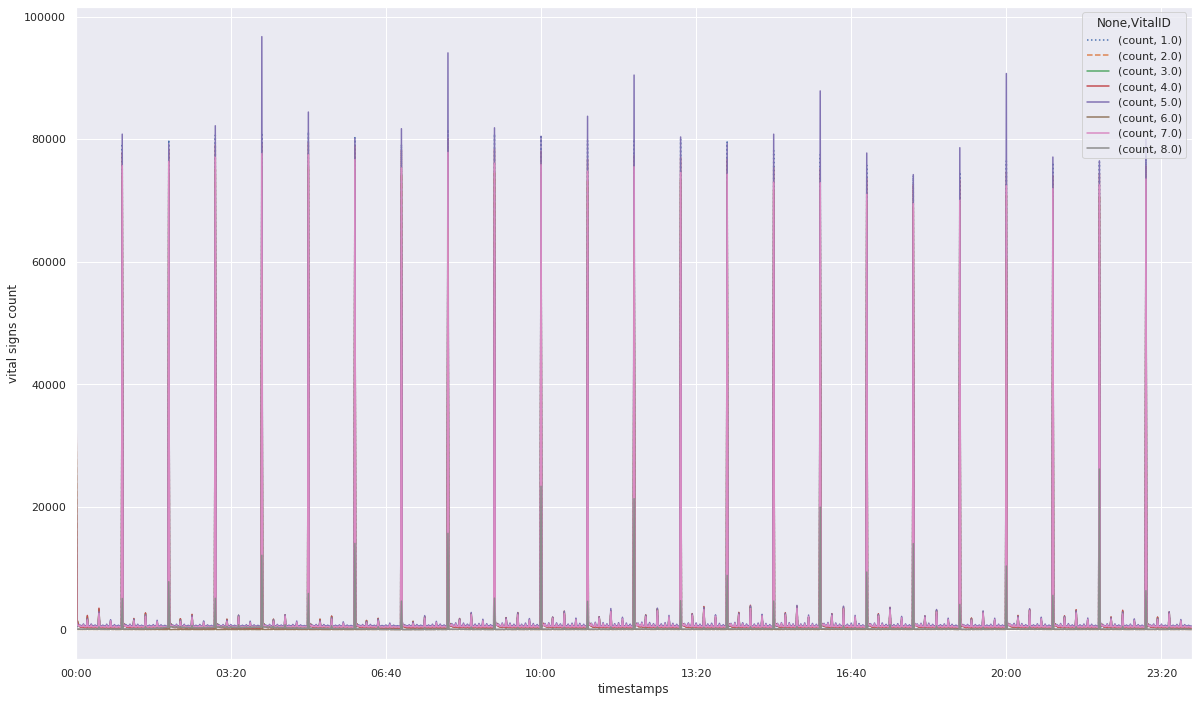

In [0]:
fig, ax = plt.subplots(figsize=(20,12))

df_time1.plot(ax=ax,style=[':', '--', '-'])
plt.ylabel('vital signs count');
#The vital signs were measured and recorded hourly in general


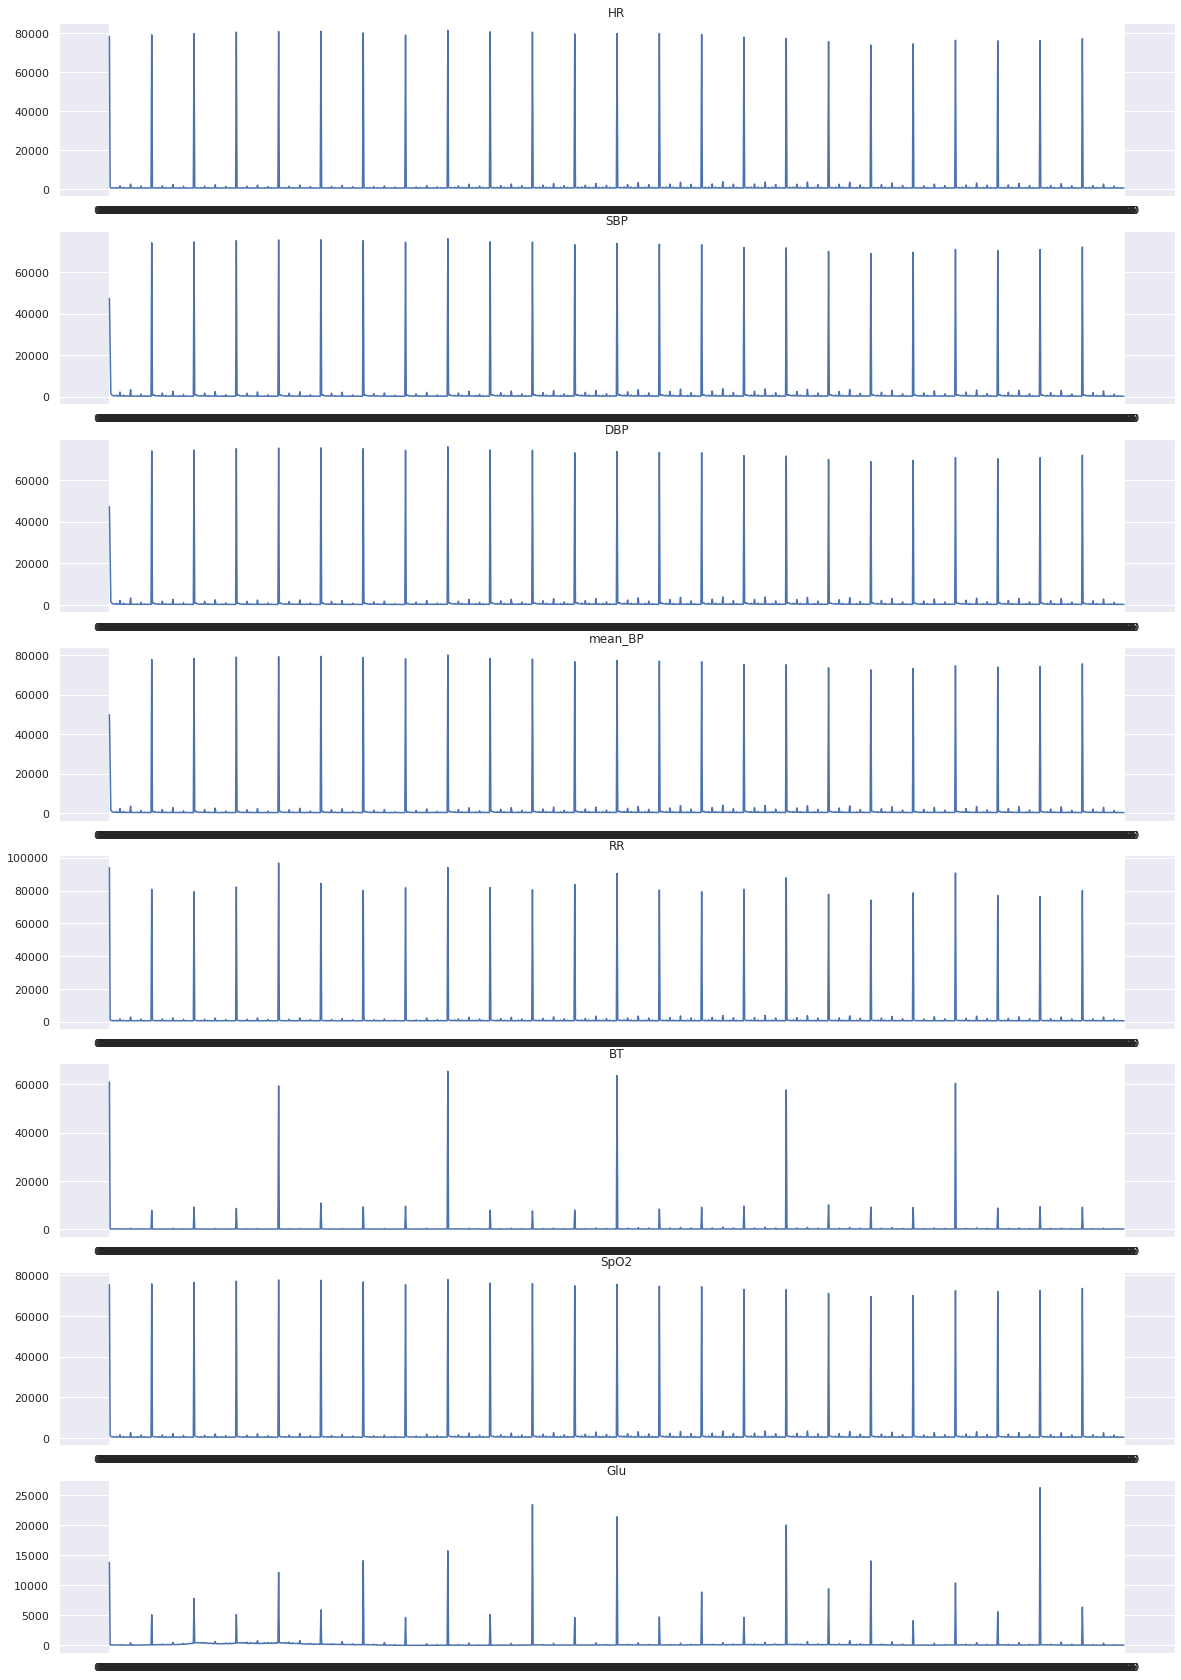

In [0]:
#ditribution of vital signs measurement by minute
# 

fig, ax = plt.subplots(8,figsize=(20,30))
columns = ['HR','SBP','DBP','mean_BP','RR','BT','SpO2','Glu']
for i,col in tqdm_notebook(enumerate(columns)):
    df_time1 = df_time[df_time['VitalID']==i+1]
    df_time1 = df_time1.drop(columns=['VitalID'])
    ax[i].plot(df_time1['timestamps'],df_time1['count'])
    ax[i].set_title(col)

In [0]:
#time distribution
query6_2= """
WITH vitals AS (
  select ie.subject_id, ie.hadm_id, ie.icustay_id
  , case
    when itemid in (211,220045) and valuenum > 0 and valuenum < 300 then 1 -- HeartRate
    when itemid in (51,442,455,6701,220179,220050) and valuenum > 0 and valuenum < 400 then 2 -- SysBP
    when itemid in (8368,8440,8441,8555,220180,220051) and valuenum > 0 and valuenum < 300 then 3 -- DiasBP
    when itemid in (456,52,6702,443,220052,220181,225312) and valuenum > 0 and valuenum < 300 then 4 -- MeanBP
    when itemid in (615,618,220210,224690) and valuenum > 0 and valuenum < 70 then 5 -- RespRate
    when itemid in (223761,678) and valuenum > 70 and valuenum < 120  then 6 -- TempF, converted to degC in valuenum call
    when itemid in (223762,676) and valuenum > 10 and valuenum < 50  then 6 -- TempC
    when itemid in (646,220277) and valuenum > 0 and valuenum <= 100 then 7 -- SpO2
    when itemid in (807,811,1529,3745,3744,225664,220621,226537) and valuenum > 0 then 8 -- Glucose

    else null end as VitalID
      -- convert F to C
  , case when itemid in (223761,678) then (valuenum-32)/1.8 else valuenum end as valuenum,
  ce.charttime, FORMAT_DATETIME("%H",ce.charttime) AS timestamps

  from `mimiciii-database.MIMIC3_V1_4.ICUSTAYS` AS ie
  left join `mimiciii-database.MIMIC3_V1_4.CHARTEVENTS` ce
  on ie.icustay_id = ce.icustay_id
  and ce.charttime between ie.intime and ie.outtime
  and DATETIME_DIFF(ce.charttime, ie.intime, SECOND) > 0
  and DATETIME_DIFF(ce.charttime, ie.outtime, SECOND) < 0
  -- exclude rows marked as error
  and (ce.error IS NULL or ce.error = 0)
  where ce.itemid in
  (
  -- HEART RATE
  211, --"Heart Rate"
  220045, --"Heart Rate"

  -- Systolic/diastolic

  51, --	Arterial BP [Systolic]
  442, --	Manual BP [Systolic]
  455, --	NBP [Systolic]
  6701, --	Arterial BP #2 [Systolic]
  220179, --	Non Invasive Blood Pressure systolic
  220050, --	Arterial Blood Pressure systolic

  8368, --	Arterial BP [Diastolic]
  8440, --	Manual BP [Diastolic]
  8441, --	NBP [Diastolic]
  8555, --	Arterial BP #2 [Diastolic]
  220180, --	Non Invasive Blood Pressure diastolic
  220051, --	Arterial Blood Pressure diastolic


  -- MEAN ARTERIAL PRESSURE
  456, --"NBP Mean"
  52, --"Arterial BP Mean"
  6702, --	Arterial BP Mean #2
  443, --	Manual BP Mean(calc)
  220052, --"Arterial Blood Pressure mean"
  220181, --"Non Invasive Blood Pressure mean"
  225312, --"ART BP mean"

  -- RESPIRATORY RATE
  618,--	Respiratory Rate
  615,--	Resp Rate (Total)
  220210,--	Respiratory Rate
  224690, --	Respiratory Rate (Total)


  -- SPO2, peripheral
  646, 220277,

  -- GLUCOSE, both lab and fingerstick
  807,--	Fingerstick Glucose
  811,--	Glucose (70-105)
  1529,--	Glucose
  3745,--	BloodGlucose
  3744,--	Blood Glucose
  225664,--	Glucose finger stick
  220621,--	Glucose (serum)
  226537,--	Glucose (whole blood)

  -- TEMPERATURE
  223762, -- "Temperature Celsius"
  676,	-- "Temperature C"
  223761, -- "Temperature Fahrenheit"
  678 --	"Temperature F"

  )
  AND ie.dbsource = 'metavision'
 )
SELECT timestamps, VitalID, COUNT(VitalID) AS count
FROM vitals
GROUP BY timestamps, VitalID
ORDER BY timestamps, VitalID
--LIMIT 10000
"""

In [0]:
df_time = client.query(query6_2, project=project_id).to_dataframe()


In [0]:
df_time = df_time.dropna()
df_time

,timestamps,VitalID,count
1,00,1.0,112432
2,00,2.0,98432
3,00,3.0,98378
4,00,4.0,102360
5,00,5.0,138383
...,...,...,...
211,23,4.0,102237
212,23,5.0,123869
213,23,6.0,11294
214,23,7.0,107863


In [0]:
df_time1 = df_time[df_time['VitalID']==1]
df_time1 = df_time1.drop(columns=['VitalID'])
df_time1

,timestamps,count
1,00,112432
10,01,112168
19,02,112361
28,03,112327
37,04,113183
46,05,112714
55,06,111152
64,07,110631
73,08,117304
82,09,117303


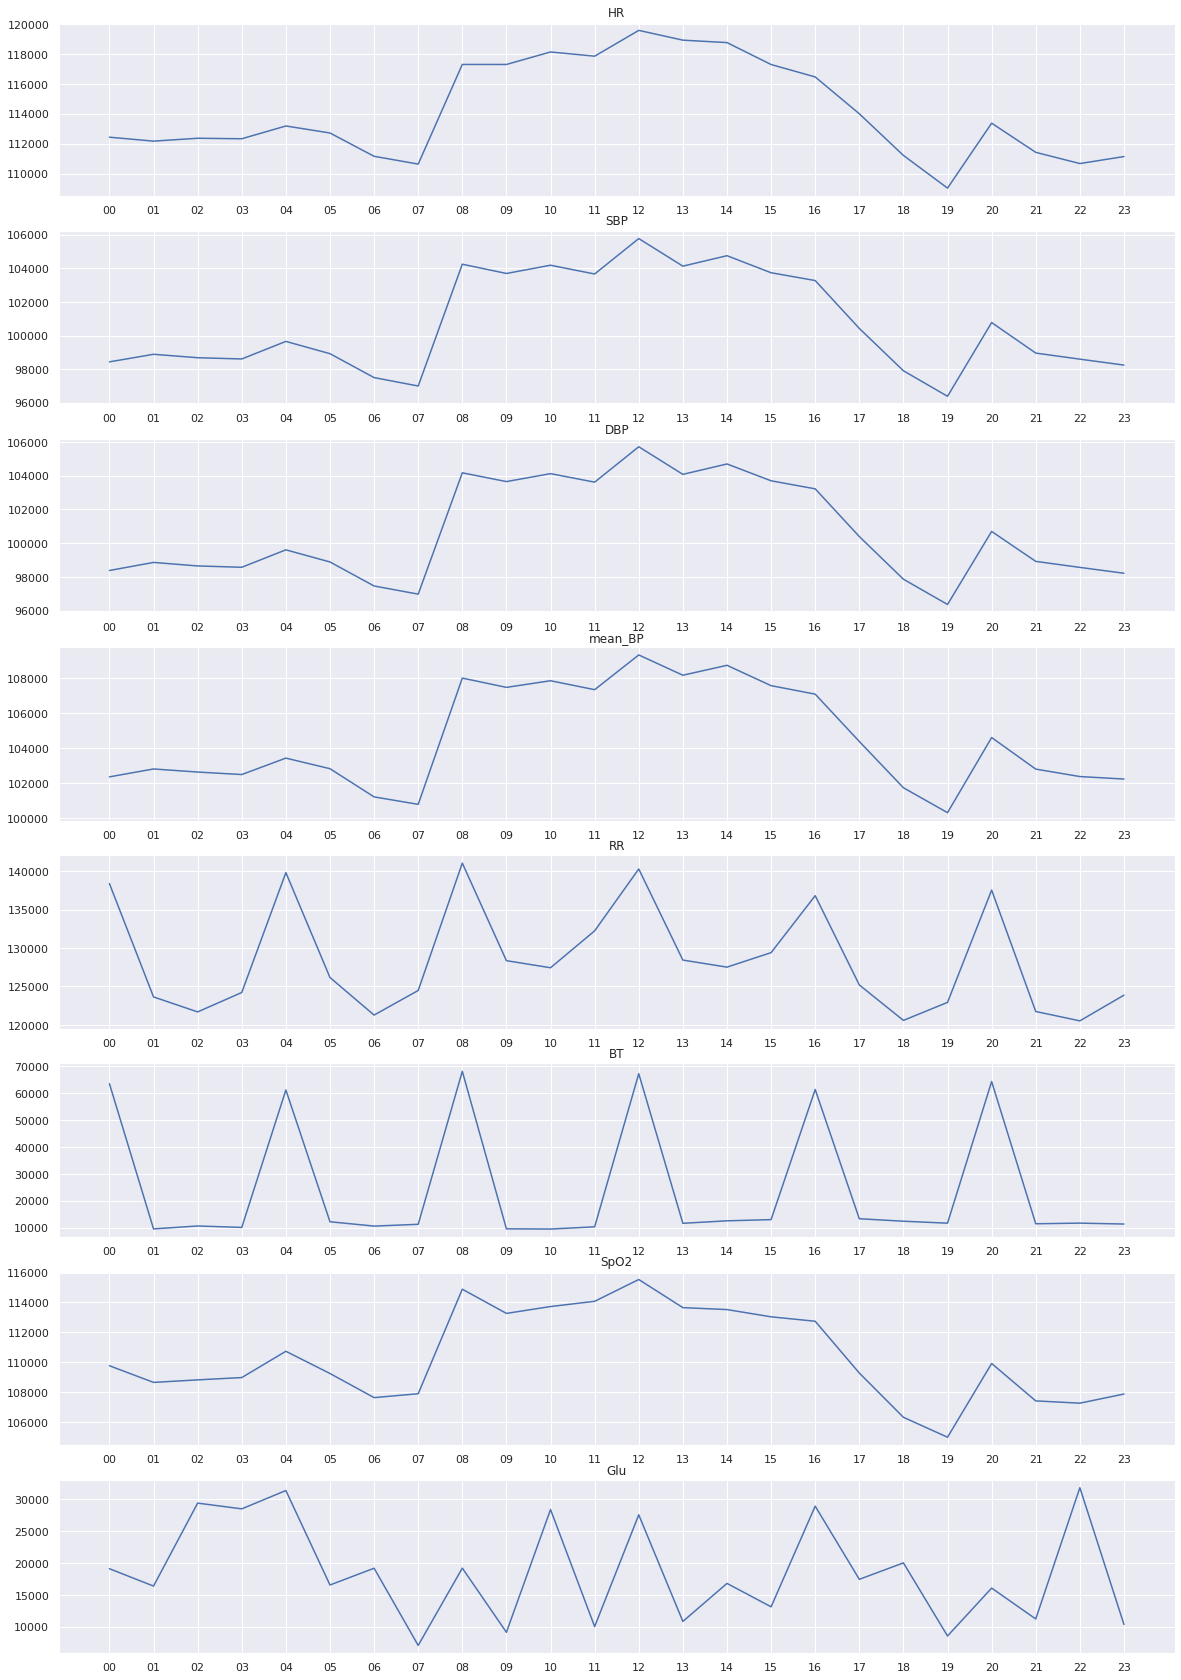

In [0]:
#ditribution of vital signs measurement by hour
# 

fig, ax = plt.subplots(8,figsize=(20,30))
columns = ['HR','SBP','DBP','mean_BP','RR','BT','SpO2','Glu']
for i,col in enumerate(columns):
    df_time1 = df_time[df_time['VitalID']==i+1]
    df_time1 = df_time1.drop(columns=['VitalID'])
    ax[i].plot(df_time1['timestamps'],df_time1['count'])
    ax[i].set_title(col)

In [0]:
#data distribution, query all datapoints from eligible ICU admissions
query6_3 = """
WITH sample_icu AS(
SELECT icustay_id
FROM `mimiciii-database.MIMIC3_V1_4.ICUSTAYS` 
WHERE dbsource = 'metavision'
--ORDER BY rand()
--LIMIT 1000
)
  select ie.subject_id, ie.hadm_id, ie.icustay_id,ie.intime,ie.outtime,
  ce.charttime
  , case
    when itemid in (211,220045) and valuenum > 0 and valuenum < 300 then 1 -- HeartRate
    when itemid in (51,442,455,6701,220179,220050) and valuenum > 0 and valuenum < 400 then 2 -- SysBP
    when itemid in (8368,8440,8441,8555,220180,220051) and valuenum > 0 and valuenum < 300 then 3 -- DiasBP
    when itemid in (456,52,6702,443,220052,220181,225312) and valuenum > 0 and valuenum < 300 then 4 -- MeanBP
    when itemid in (615,618,220210,224690) and valuenum > 0 and valuenum < 70 then 5 -- RespRate
    when itemid in (223761,678) and valuenum > 70 and valuenum < 120  then 6 -- TempF, converted to degC in valuenum call
    when itemid in (223762,676) and valuenum > 10 and valuenum < 50  then 6 -- TempC
    when itemid in (646,220277) and valuenum > 0 and valuenum <= 100 then 7 -- SpO2
    when itemid in (807,811,1529,3745,3744,225664,220621,226537) and valuenum > 0 and valuenum <1000 then 8 -- Glucose

    else null end as VitalID
      -- convert F to C
  , case when itemid in (223761,678) then (valuenum-32)/1.8 else valuenum end as valuenum

  from `mimiciii-database.MIMIC3_V1_4.ICUSTAYS` AS ie
  left join `mimiciii-database.MIMIC3_V1_4.CHARTEVENTS` ce
  on ie.icustay_id = ce.icustay_id
  and ce.charttime between ie.intime and ie.outtime
  and DATETIME_DIFF(ce.charttime, ie.intime, SECOND) > 0
  and DATETIME_DIFF(ce.charttime, ie.outtime, SECOND) < 0
  -- exclude rows marked as error
  and (ce.error IS NULL or ce.error = 0)
  Right join sample_icu as si
  on ie.icustay_id = si.icustay_id
  where ce.itemid in
  (
  -- HEART RATE
  211, --"Heart Rate"
  220045, --"Heart Rate"

  -- Systolic/diastolic

  51, --	Arterial BP [Systolic]
  442, --	Manual BP [Systolic]
  455, --	NBP [Systolic]
  6701, --	Arterial BP #2 [Systolic]
  220179, --	Non Invasive Blood Pressure systolic
  220050, --	Arterial Blood Pressure systolic

  8368, --	Arterial BP [Diastolic]
  8440, --	Manual BP [Diastolic]
  8441, --	NBP [Diastolic]
  8555, --	Arterial BP #2 [Diastolic]
  220180, --	Non Invasive Blood Pressure diastolic
  220051, --	Arterial Blood Pressure diastolic


  -- MEAN ARTERIAL PRESSURE
  456, --"NBP Mean"
  52, --"Arterial BP Mean"
  6702, --	Arterial BP Mean #2
  443, --	Manual BP Mean(calc)
  220052, --"Arterial Blood Pressure mean"
  220181, --"Non Invasive Blood Pressure mean"
  225312, --"ART BP mean"

  -- RESPIRATORY RATE
  618,--	Respiratory Rate
  615,--	Resp Rate (Total)
  220210,--	Respiratory Rate
  224690, --	Respiratory Rate (Total)


  -- SPO2, peripheral
  646, 220277,

  -- GLUCOSE, both lab and fingerstick
  807,--	Fingerstick Glucose
  811,--	Glucose (70-105)
  1529,--	Glucose
  3745,--	BloodGlucose
  3744,--	Blood Glucose
  225664,--	Glucose finger stick
  220621,--	Glucose (serum)
  226537,--	Glucose (whole blood)

  -- TEMPERATURE
  223762, -- "Temperature Celsius"
  676,	-- "Temperature C"
  223761, -- "Temperature Fahrenheit"
  678 --	"Temperature F"
  )

"""

In [0]:
%%time
df_datapoint = client.query(query6_3, project=project_id).to_dataframe()


CPU times: user 14min 16s, sys: 19.3 s, total: 14min 35s
Wall time: 28min 31s


In [0]:
icustay_list = client.query(query4_2, project=project_id).to_dataframe()
mort_list = icustay_list[icustay_list['in_hospital_mortality']==1]['icustay_id'].to_list()
survive_list = icustay_list[icustay_list['in_hospital_mortality']==0]['icustay_id'].to_list()


In [0]:
mort_table = df_datapoint[df_datapoint['icustay_id'].isin(mort_list)]
surv_table = df_datapoint[df_datapoint['icustay_id'].isin(survive_list)]
#df_time1['icustay_id'].unique()
#surv_table

In [0]:
# check data descriptive statistics, mortality group
columns = ['HR','SBP','DBP','mean_BP','RR','BT','SpO2','Glu']
for i,col in enumerate(columns):
    df_time2 = mort_table[mort_table['VitalID']==i+1]
    #df_time1 = df_time1.drop(columns=['VitalID'])
    print(col)
    print(df_time2['valuenum'].describe())
    print()

HR
count    437698.000000
mean         94.124546
std          20.476445
min           1.000000
25%          80.000000
50%          94.000000
75%         108.000000
max         250.000000
Name: valuenum, dtype: float64

SBP
count    354223.000000
mean        113.258292
std          23.691195
min           0.110000
25%          98.000000
50%         110.000000
75%         127.000000
max         341.000000
Name: valuenum, dtype: float64

DBP
count    354058.000000
mean         56.587432
std          13.903051
min           1.000000
25%          48.000000
50%          55.000000
75%          64.000000
max         298.000000
Name: valuenum, dtype: float64

mean_BP
count    373946.000000
mean         73.874786
std          17.160135
min           1.000000
25%          64.000000
50%          72.000000
75%          82.000000
max         299.000000
Name: valuenum, dtype: float64

RR
count    547799.000000
mean         22.134677
std           6.079718
min           1.000000
25%          18.000000

In [0]:
# check data descriptive statistics, survival group
columns = ['HR','SBP','DBP','mean_BP','RR','BT','SpO2','Glu']
for i,col in enumerate(columns):
    df_time2 = surv_table[surv_table['VitalID']==i+1]
    
    #df_time1 = df_time1.drop(columns=['VitalID'])
    print(col)
    print(df_time2['valuenum'].describe())
    print()

HR
count    2.211842e+06
mean     8.626308e+01
std      1.807508e+01
min      1.000000e+00
25%      7.300000e+01
50%      8.500000e+01
75%      9.800000e+01
max      2.800000e+02
Name: valuenum, dtype: float64

SBP
count    1.987663e+06
mean     1.220760e+02
std      2.307460e+01
min      2.000000e-01
25%      1.050000e+02
50%      1.200000e+02
75%      1.370000e+02
max      3.550000e+02
Name: valuenum, dtype: float64

DBP
count    1.986914e+06
mean     6.247465e+01
std      1.486084e+01
min      1.000000e+00
25%      5.200000e+01
50%      6.100000e+01
75%      7.100000e+01
max      2.940000e+02
Name: valuenum, dtype: float64

mean_BP
count    2.058596e+06
mean     7.935692e+01
std      1.695670e+01
min      4.300000e-01
25%      6.800000e+01
50%      7.700000e+01
75%      8.900000e+01
max      2.990000e+02
Name: valuenum, dtype: float64

RR
count    2.444472e+06
mean     1.990453e+01
std      5.746085e+00
min      1.000000e+00
25%      1.600000e+01
50%      1.900000e+01
75%      2.300

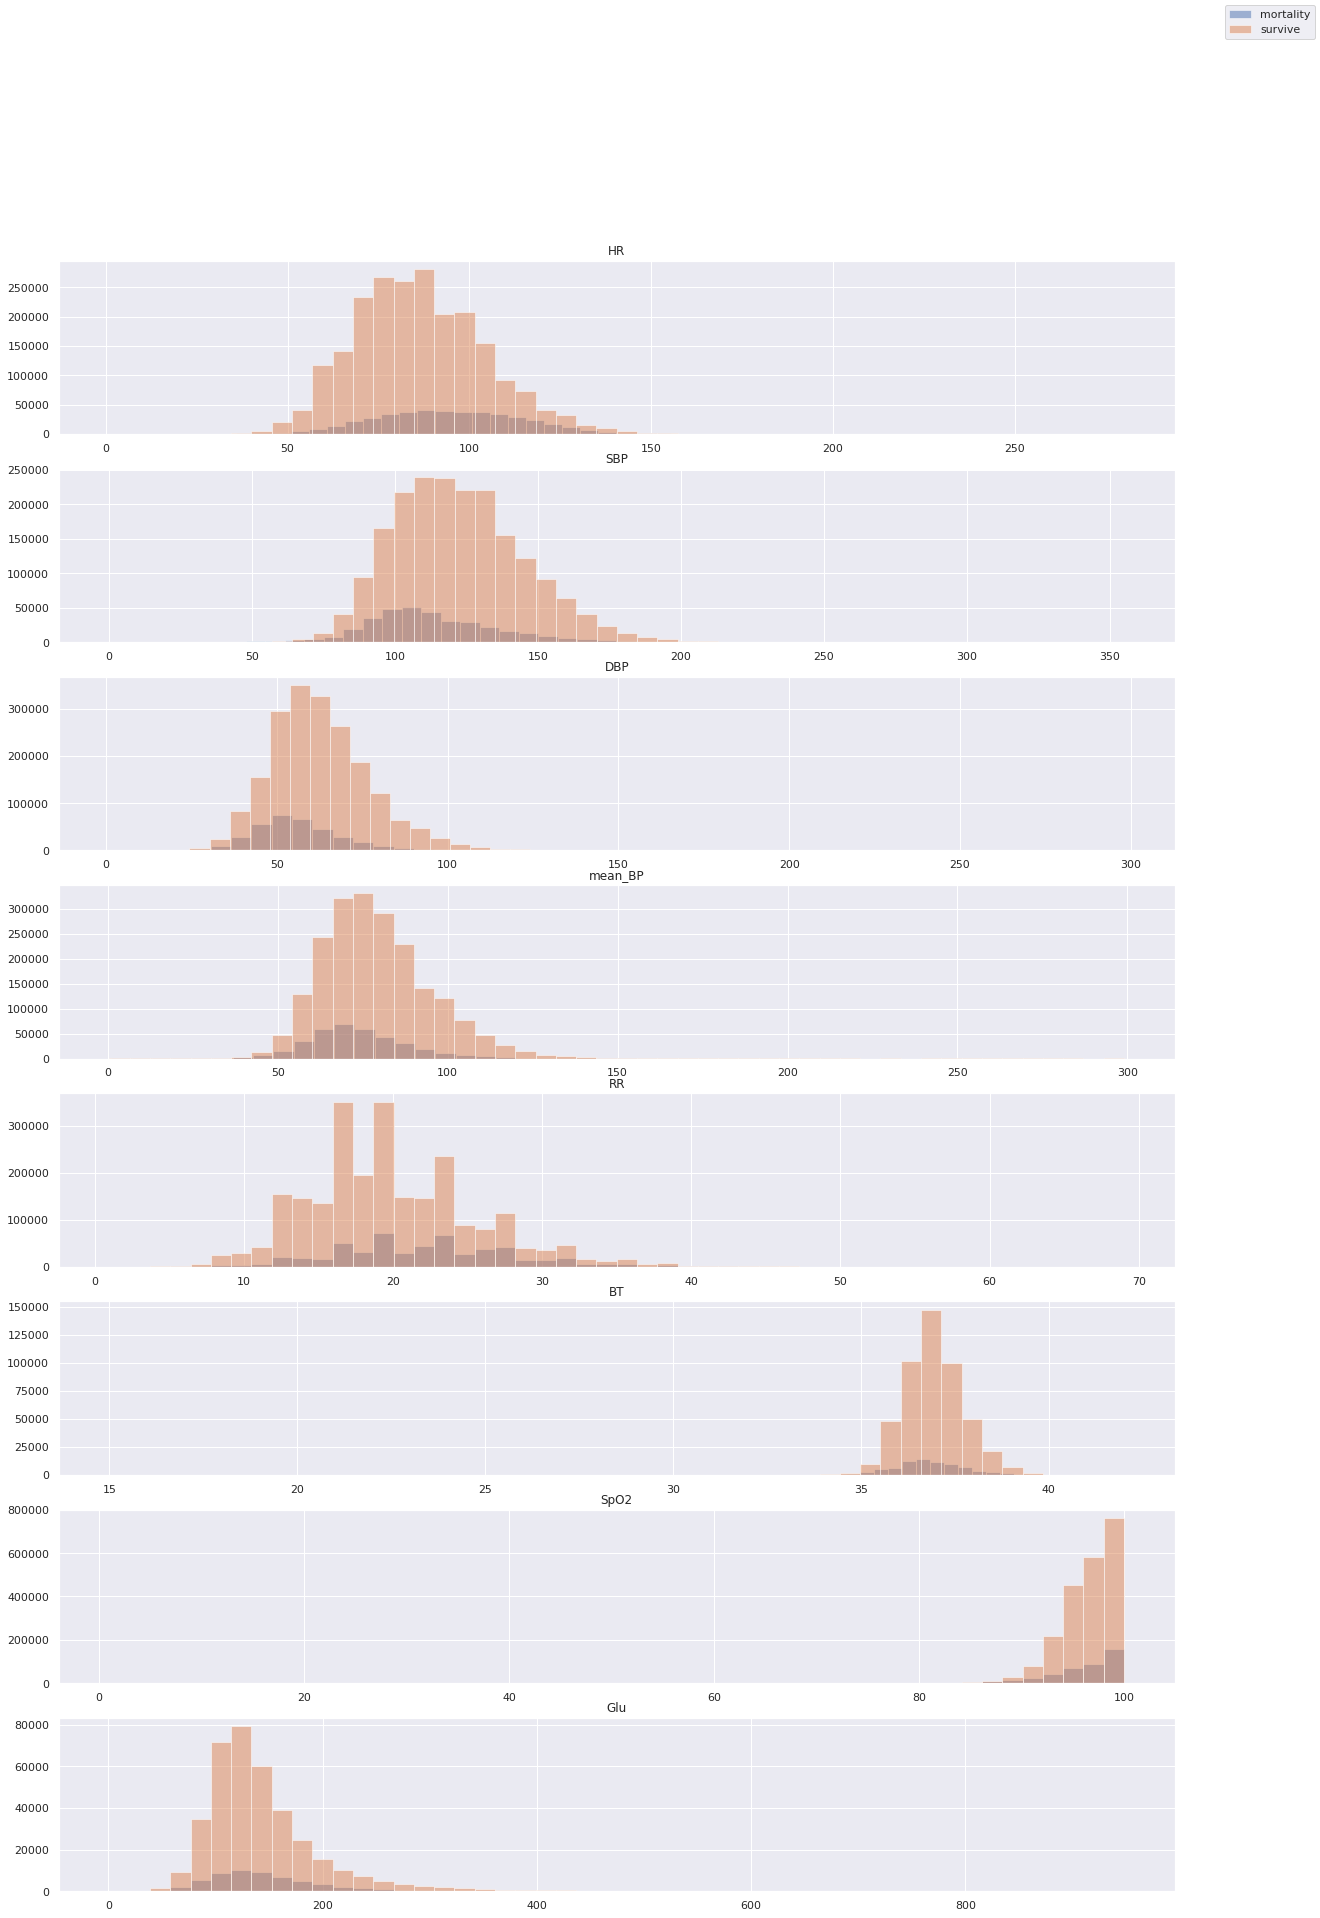

In [0]:
# compare the ditribution of vital signs measurement

fig, ax = plt.subplots(8,figsize=(20,30))
columns = ['HR','SBP','DBP','mean_BP','RR','BT','SpO2','Glu']
for i,col in enumerate(columns):
    df_time1 = mort_table[mort_table['VitalID']==i+1]
    df_time2 = surv_table[surv_table['VitalID']==i+1]
    #df_time1 = df_time1.drop(columns=['VitalID'])
    ax[i].hist(df_time1['valuenum'],bins=50,alpha=0.5)
    ax[i].hist(df_time2['valuenum'],bins=50,alpha=0.5)
    ax[i].set_title(col)
fig.legend(['mortality','survive'])

In [0]:
#data distribution - first 24hrs
query6_4 = """
WITH sample_icu AS(
SELECT icustay_id
FROM `mimiciii-database.MIMIC3_V1_4.ICUSTAYS` 
WHERE dbsource = 'metavision'
ORDER BY rand()
LIMIT 1000
)
  select ie.subject_id, ie.hadm_id, ie.icustay_id, ie.intime,ie.outtime,
  ce.charttime
  , case
    when itemid in (211,220045) and valuenum > 0 and valuenum < 300 then 1 -- HeartRate
    when itemid in (51,442,455,6701,220179,220050) and valuenum > 0 and valuenum < 400 then 2 -- SysBP
    when itemid in (8368,8440,8441,8555,220180,220051) and valuenum > 0 and valuenum < 300 then 3 -- DiasBP
    when itemid in (456,52,6702,443,220052,220181,225312) and valuenum > 0 and valuenum < 300 then 4 -- MeanBP
    when itemid in (615,618,220210,224690) and valuenum > 0 and valuenum < 70 then 5 -- RespRate
    when itemid in (223761,678) and valuenum > 70 and valuenum < 120  then 6 -- TempF, converted to degC in valuenum call
    when itemid in (223762,676) and valuenum > 10 and valuenum < 50  then 6 -- TempC
    when itemid in (646,220277) and valuenum > 0 and valuenum <= 100 then 7 -- SpO2
    when itemid in (807,811,1529,3745,3744,225664,220621,226537) and valuenum > 0 and valuenum <1000 then 8 -- Glucose

    else null end as VitalID
      -- convert F to C
  , case when itemid in (223761,678) then (valuenum-32)/1.8 else valuenum end as valuenum

  from `mimiciii-database.MIMIC3_V1_4.ICUSTAYS` AS ie
  left join `mimiciii-database.MIMIC3_V1_4.CHARTEVENTS` ce
  on ie.icustay_id = ce.icustay_id
  and ce.charttime between ie.intime and ie.outtime
  and DATETIME_DIFF(ce.charttime, ie.intime, SECOND) > 0
  and DATETIME_DIFF(ce.charttime, ie.intime, HOUR) <= 24
  -- exclude rows marked as error
  and (ce.error IS NULL or ce.error = 0)
  RIGHT join sample_icu as si
  on ie.icustay_id = si.icustay_id
  where ce.itemid in
  (
  -- HEART RATE
  211, --"Heart Rate"
  220045, --"Heart Rate"

  -- Systolic/diastolic

  51, --	Arterial BP [Systolic]
  442, --	Manual BP [Systolic]
  455, --	NBP [Systolic]
  6701, --	Arterial BP #2 [Systolic]
  220179, --	Non Invasive Blood Pressure systolic
  220050, --	Arterial Blood Pressure systolic

  8368, --	Arterial BP [Diastolic]
  8440, --	Manual BP [Diastolic]
  8441, --	NBP [Diastolic]
  8555, --	Arterial BP #2 [Diastolic]
  220180, --	Non Invasive Blood Pressure diastolic
  220051, --	Arterial Blood Pressure diastolic


  -- MEAN ARTERIAL PRESSURE
  456, --"NBP Mean"
  52, --"Arterial BP Mean"
  6702, --	Arterial BP Mean #2
  443, --	Manual BP Mean(calc)
  220052, --"Arterial Blood Pressure mean"
  220181, --"Non Invasive Blood Pressure mean"
  225312, --"ART BP mean"

  -- RESPIRATORY RATE
  618,--	Respiratory Rate
  615,--	Resp Rate (Total)
  220210,--	Respiratory Rate
  224690, --	Respiratory Rate (Total)


  -- SPO2, peripheral
  646, 220277,

  -- GLUCOSE, both lab and fingerstick
  807,--	Fingerstick Glucose
  811,--	Glucose (70-105)
  1529,--	Glucose
  3745,--	BloodGlucose
  3744,--	Blood Glucose
  225664,--	Glucose finger stick
  220621,--	Glucose (serum)
  226537,--	Glucose (whole blood)

  -- TEMPERATURE
  223762, -- "Temperature Celsius"
  676,	-- "Temperature C"
  223761, -- "Temperature Fahrenheit"
  678 --	"Temperature F"
  )
  ORDER BY ie.icustay_id, 
  ce.charttime
"""

In [0]:
df_datapoint1000 = client.query(query6_4, project=project_id).to_dataframe()


In [0]:
#df_time = df_time.sort_values(by=['charttime'])
df_time1 = df_datapoint1000[df_datapoint1000['icustay_id']==200231]
df_time1['charttime'] = pd.to_datetime(df_time1['charttime'])
df_time1['relativetime'] = pd.to_datetime(df_time1['charttime'])- df_time1['intime'] + pd.to_datetime('2000/01/01')

#df_time1

In [0]:
# check data point, counts within 24 hours
maxim = []
minim = []
gap = []
count = []
columns = ['HR','SBP','DBP','mean_BP','RR','BT','SpO2','Glu']
for i in range(1,9):
    time1 = df_time1[df_time1['VitalID']==i]['charttime'].max()
    maxim.append(pd.to_datetime(time1))
    time2 = df_time1[df_time1['VitalID']==i]['charttime'].min()
    minim.append(pd.to_datetime(time2))
    gap.append(pd.to_datetime(time1) - pd.to_datetime(time2))
    n= df_time1[df_time1['VitalID']==i]['charttime'].count()
    count.append(n)
df = pd.DataFrame({'items':columns,'First_data':minim, "Last_data":maxim, "duration":gap, "datapoint":count})
df.set_index('items')

,First_data,Last_data,duration,datapoint
items,,,,
HR,2127-03-09 16:45:00,2127-03-10 15:00:00,22:15:00,31
SBP,2127-03-09 16:45:00,2127-03-10 15:00:00,22:15:00,30
DBP,2127-03-09 16:45:00,2127-03-10 15:00:00,22:15:00,30
mean_BP,2127-03-09 16:45:00,2127-03-10 15:00:00,22:15:00,30
RR,2127-03-09 16:45:00,2127-03-10 15:00:00,22:15:00,31
BT,2127-03-09 16:57:00,2127-03-10 12:00:00,19:03:00,6
SpO2,2127-03-09 16:46:00,2127-03-10 15:00:00,22:14:00,31
Glu,2127-03-09 18:03:00,2127-03-10 12:00:00,17:57:00,9


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

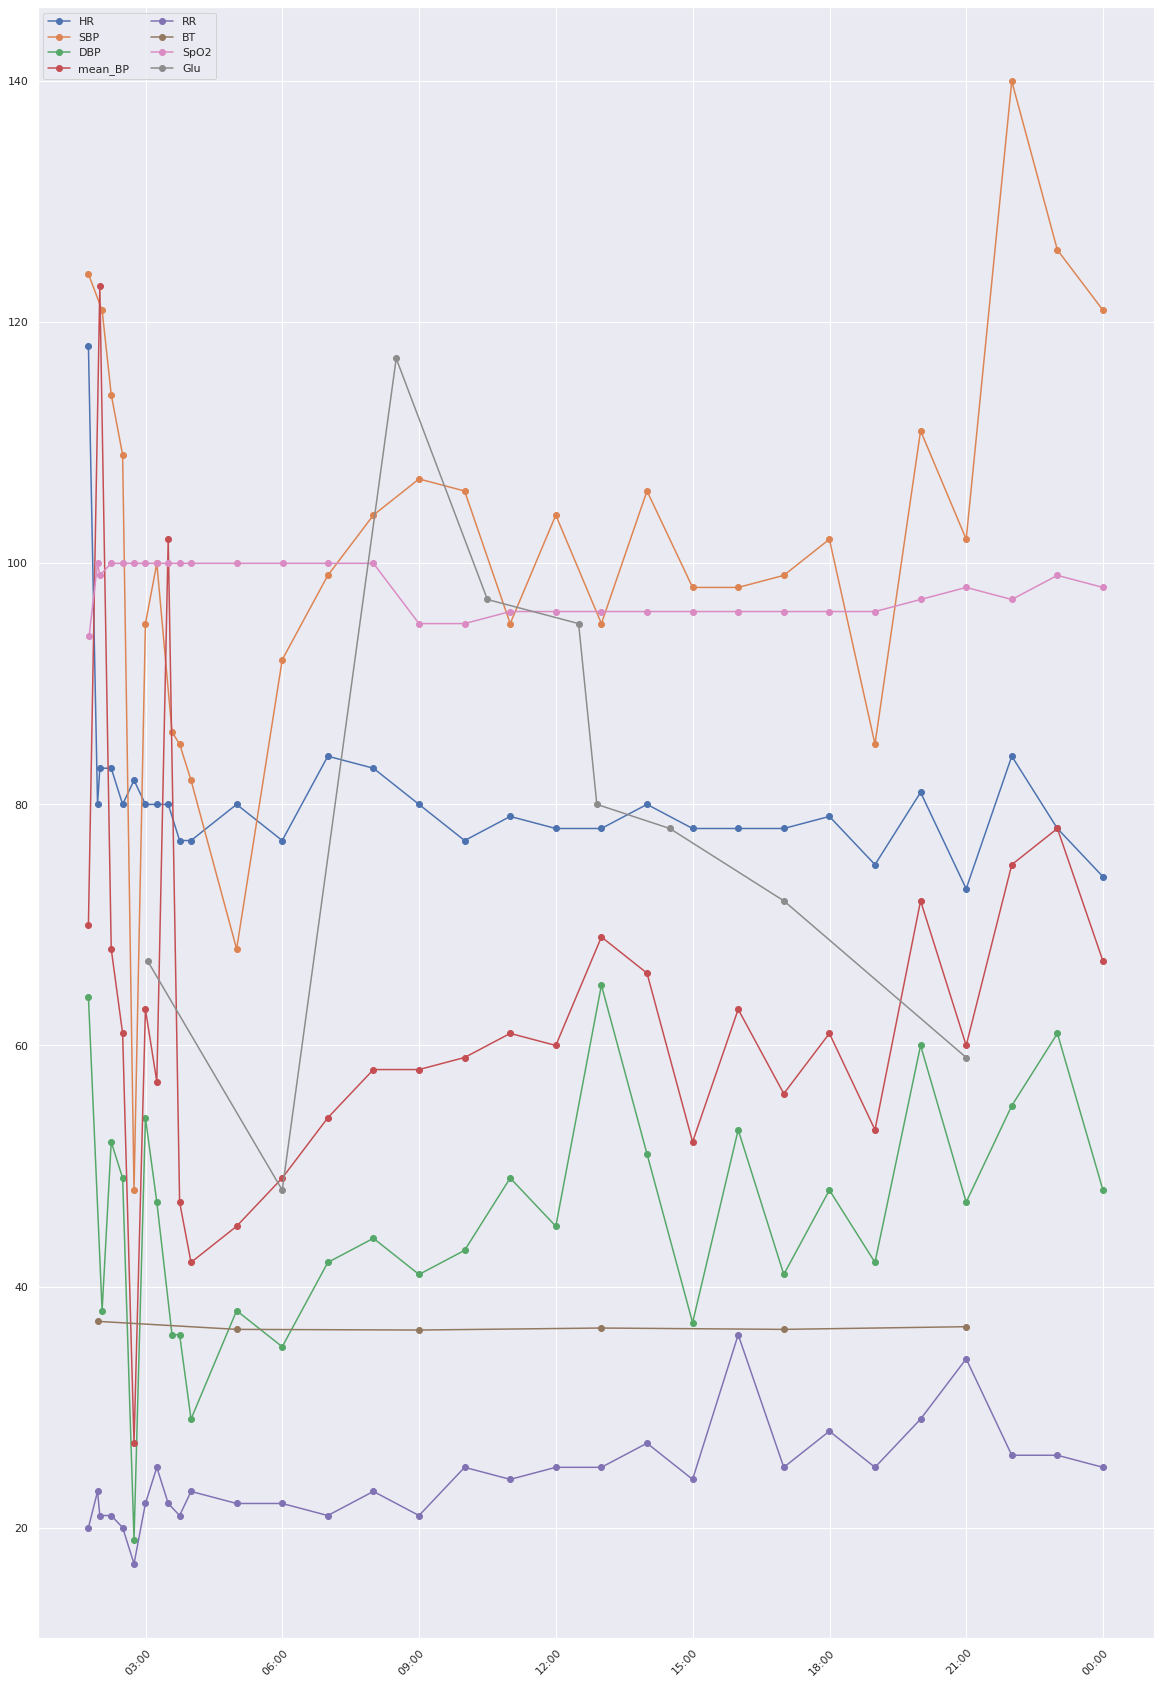

In [0]:
# Visualize data distributions within first 24hrs of admission of one admission
import matplotlib.dates as mdates
#import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(20,30))
columns = ['HR','SBP','DBP','mean_BP','RR','BT','SpO2','Glu']
for i in range(1,9):
    df_time2 = df_time1[df_time1['VitalID']==i]
   # df_time1 = df_time1.drop(columns=['VitalID'])
    #df_time2 = df_time2.sort_values(by=['charttime'])
    plt.plot(df_time2['relativetime'],df_time2['valuenum'],'-o')
plt.legend(columns,ncol=2, loc='upper left')
# Define the date format
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

In [0]:
# extract datapoint by given time interval
df_time_idx = df_time1.set_index('relativetime')

In [0]:
# extract the first data points within each one hour interval
q = df_time_idx.groupby([pd.Grouper(freq='60Min'),'VitalID'])
q = q.first()['valuenum'].unstack()
#.fillna(method='ffill').fillna(method='bfill')
q

VitalID,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
relativetime,,,,,,,,
2000-01-01 01:00:00,118.0,124.0,64.0,70.0,20.0,37.111111,94.0,NaN
2000-01-01 02:00:00,83.0,121.0,38.0,68.0,21.0,NaN,100.0,NaN
2000-01-01 03:00:00,80.0,100.0,47.0,57.0,25.0,NaN,100.0,67.0
2000-01-01 04:00:00,80.0,68.0,38.0,45.0,22.0,36.444444,100.0,NaN
2000-01-01 05:00:00,77.0,92.0,35.0,49.0,22.0,NaN,NaN,48.0
2000-01-01 06:00:00,84.0,99.0,42.0,54.0,21.0,NaN,100.0,NaN
2000-01-01 07:00:00,83.0,104.0,44.0,58.0,23.0,NaN,100.0,NaN
2000-01-01 08:00:00,80.0,107.0,41.0,58.0,21.0,36.388889,95.0,117.0
2000-01-01 09:00:00,77.0,106.0,43.0,59.0,25.0,NaN,95.0,NaN


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

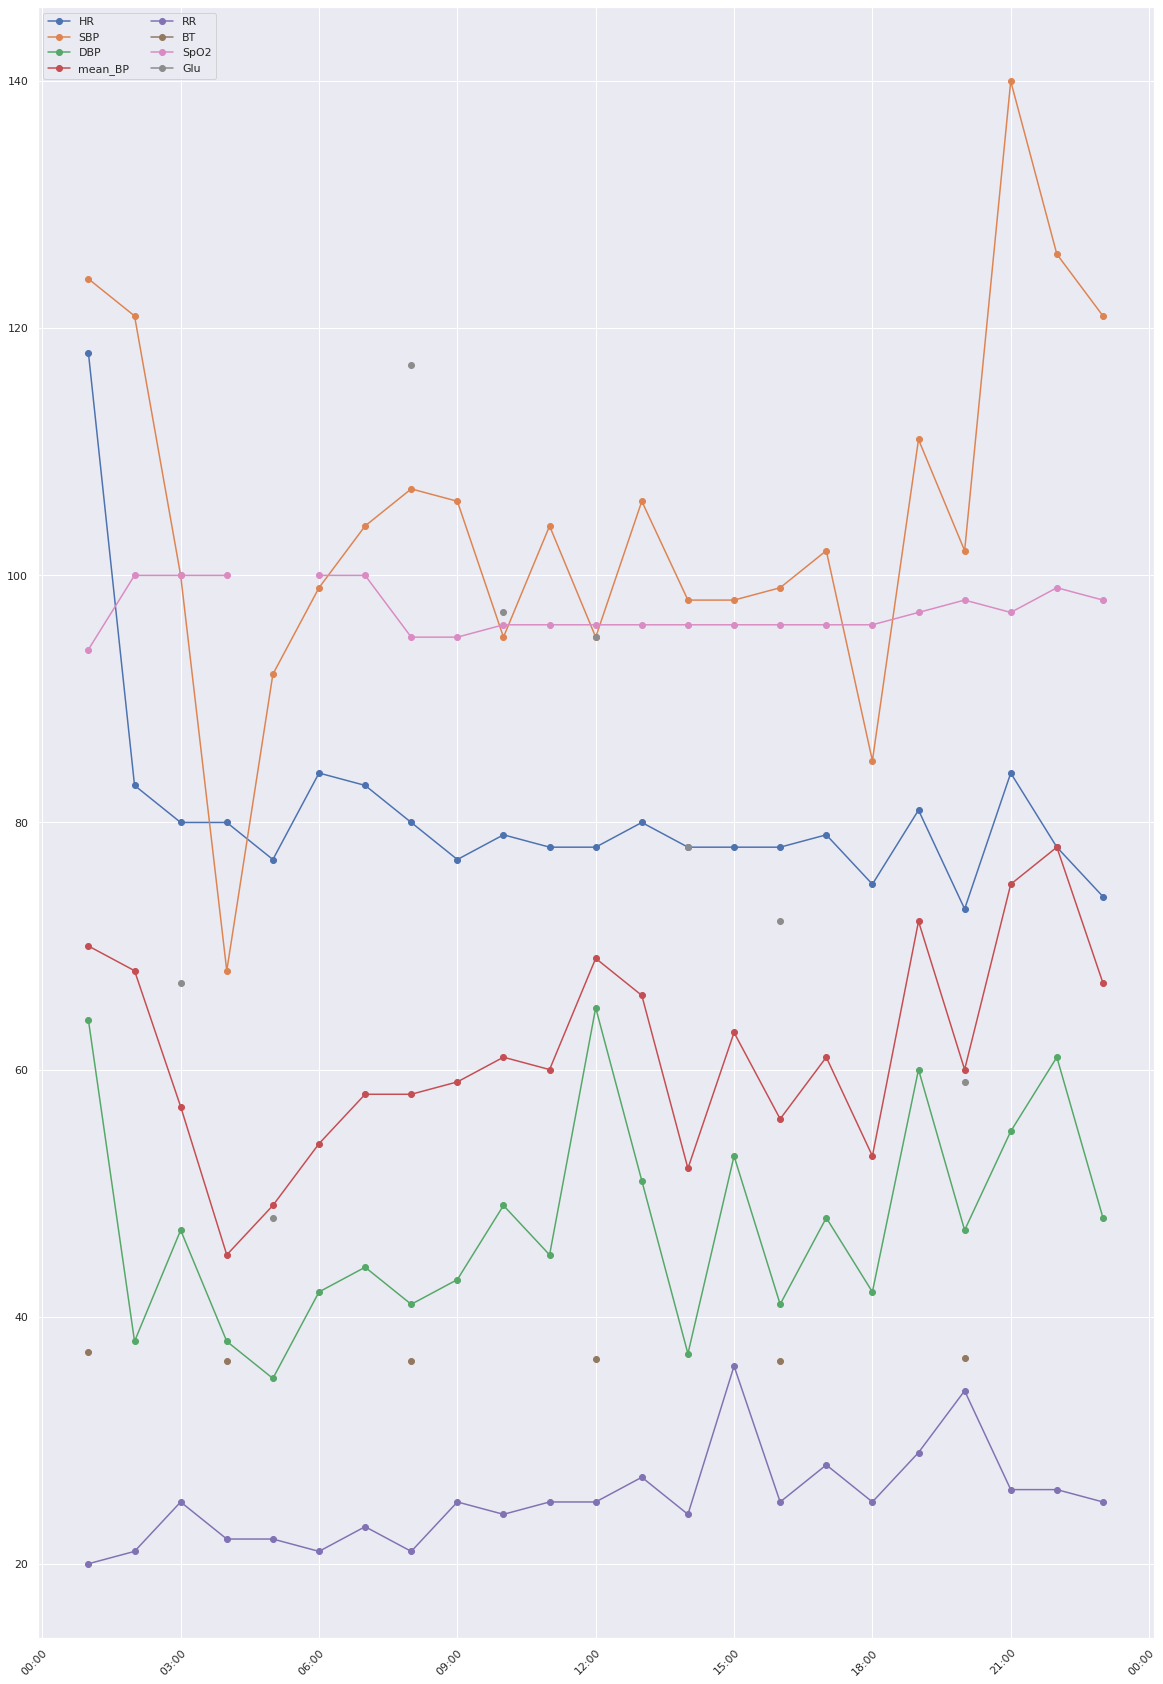

In [0]:
# plot distribution
fig, ax = plt.subplots(figsize=(20,30))
columns = ['HR','SBP','DBP','mean_BP','RR','BT','SpO2','Glu']
for i in range(1,9):
    plt.plot(q.index,q.loc[:,i],'-o')
plt.legend(columns,ncol=2, loc='upper left')
# Define the date format
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

In [0]:
# check data quality and missing data.
#1000 sample admissions
sample = df_datapoint1000['icustay_id'].unique()
len(sample)

991

In [0]:
# create data, label from samples
#icu_stay = [269035, 282599, 263882, 272764, 227395, 252212]
data = []
missing_data = []
label = []
#columns = ['HR','SBP','DBP','mean_BP','RR','BT','SpO2','Glu','MVent','O2T']
#check_tabel = pd.DataFrame(columns = ['icustay_id','HR','SBP','DBP','mean_BP','RR','BT','SpO2','Glu','MVent','O2T','mortality'])
columns = ['HR','SBP','DBP','mean_BP','RR','BT','SpO2','Glu']
#check_tabel = pd.DataFrame(columns = ['icustay_id','HR','SBP','DBP','mean_BP','RR','BT','SpO2','Glu','mortality'])
m = np.zeros((24,8))
for idx in tqdm_notebook(sample):
  df_time1 = df_datapoint1000[df_datapoint1000['icustay_id']==idx]
  #df_time = df_time.sort_values(by=['charttime'])
  df_time1['charttime'] = pd.to_datetime(df_time1['charttime'])
  df_time1['relativetime'] = pd.to_datetime(df_time1['charttime'])- df_time1['intime'] + pd.to_datetime('2000/01/01')
          # extract datapoint by given time interval
  df_time_idx = df_time1.set_index('relativetime')
          # group by hour
  q = df_time_idx.groupby([pd.Grouper(freq='60Min'),'VitalID'])
  q = q.first()['valuenum'].unstack()
  #missing_data.append(q.isnull().sum(axis=0).to_numpy())
  #l = df_icustay[df_icustay['icustay_id']==idx]['in_hospital_mortality']
  #data.append(q.values)
#missing_data_per = np.array(missing_data)
#print(type(missing_data_per))
#missing_data_per = missing_data_per/24
#average = missing_data_per.sum(axis=0)/len(sample)
  #fill the period gap with nan
  date = pd.to_datetime('2000-01-01 00:00:00')
  timesteps = date + pd.to_timedelta(np.arange(24), 'H')
  c = pd.DataFrame(columns = columns,index=timesteps)
  
        #matrix = []
  for i, step in enumerate(timesteps):
    for j, v in enumerate(columns):
          #print(str(step))
      y = j+1
      try:
              #matrix.append(q.loc[str(step),:].to_numpy())
        c.loc[str(step),v] = q.loc[str(step),y]
      #  if q.loc[str(step),i]==None:
          m[i,j]+= 1
      #except:
        m[i,j]+= 1
            #matrix.append(np.empty((8))*np.nan)
        #print(np.array(matrix))
        #print(np.isnan(np.array(matrix,dtype=np.float64)).sum(axis=0))
        #print(c.to_numpy())
        #print(c.isnull().sum(axis=0))
  #for var in columns:
  #        if var == 'SpO2':
  #          c[var] = (c[var]-variables_s[var]['mean'])/(variables_s[var]['max'] - variables_s[var]['min'])
  #        else:
  #          c[var] = (c[var]-variables_s[var]['mean'])/variables_s[var]['std']
        #fill missing data forward -> mean
  #c = c.fillna(method='ffill').fillna(0)
  #missing_data.append(c.isnull().sum(axis=0))
  data.append(c.to_numpy())
  #label.append(l.values[0])
  #c['icustay_id'] = idx
  #l = df_icustay[df_icustay['icustay_id']==idx]['in_hospital_mortality']
  #c['mortality'] = l.values[0]
  #check_tabel = pd.concat([check_tabel,c])
#np.array(data)
#check_tabel.to_csv('sample_checktable.csv')

In [0]:
#missing data in sample1000
data = np.array(data, dtype=np.float64)
np.isnan(data).sum(axis=0)


array([[565, 582, 582, 579, 549, 666, 577, 725],
       [238, 279, 279, 267, 232, 640, 260, 732],
       [115, 142, 141, 126, 117, 677, 126, 712],
       [ 90, 120, 120, 107,  87, 726,  98, 724],
       [ 61, 103, 103,  87,  61, 683,  74, 753],
       [ 48,  85,  85,  67,  51, 677,  63, 736],
       [ 49,  90,  90,  74,  54, 680,  64, 740],
       [ 47,  94,  94,  72,  52, 697,  64, 728],
       [ 43,  83,  83,  64,  50, 680,  58, 721],
       [ 45,  78,  77,  63,  54, 703,  61, 739],
       [ 51, 101, 100,  87,  55, 698,  72, 731],
       [ 50,  84,  84,  68,  55, 708,  77, 751],
       [ 58,  99,  99,  80,  64, 687,  82, 725],
       [ 57, 108, 108,  88,  65, 692,  85, 748],
       [ 63, 110, 110,  90,  70, 714,  89, 737],
       [ 74, 123, 123, 106,  81, 734,  99, 777],
       [ 77, 124, 124, 103,  88, 725, 109, 756],
       [ 87, 130, 130, 114,  98, 709, 117, 770],
       [ 96, 150, 151, 127, 108, 726, 130, 776],
       [123, 167, 168, 149, 133, 749, 153, 790],
       [150, 199, 19

In [0]:
# add two more features, oxygenation and machine ventilation. 
query7 = """
WITH sample_icu AS(
SELECT subject_id,hadm_id,icustay_id,intime,outtime
FROM `mimiciii-database.MIMIC3_V1_4.ICUSTAYS` 
WHERE dbsource = 'metavision')
Select s.subject_id, s.hadm_id,v.icustay_id, s.intime, s.outtime, v.charttime, v.MechVent, v.OxygenTherapy
From `mimiciii-database.MIMIC3_V1_4.ventsettings` as v
RIGHT Join sample_icu as s 
ON v.icustay_id = s.icustay_id 
  and v.charttime between s.intime and s.outtime
  and DATETIME_DIFF(v.charttime, s.intime, SECOND) > 0
  and DATETIME_DIFF(v.charttime, s.intime, HOUR) <= 24
#WHERE v.MechVent = 0 AND (v.Extubated=1 OR v.SelfExtubated=1)
ORDER BY s.icustay_id, charttime
"""

In [0]:
df_02 = client.query(query7, project=project_id).to_dataframe()
#df_02

In [0]:
df_mv = df_02.iloc[:,:6]
df_mv['VitalID'] = 9
df_mv['valuenum'] = df_02['MechVent']
df_ot = df_02.iloc[:,:6]
df_ot['VitalID'] = 10
df_ot['valuenum'] = df_02['OxygenTherapy']
df_02transform = pd.concat([df_mv,df_ot])
df_02transform = df_02transform.sort_values(by=['icustay_id','charttime'])
df_02transform = df_02transform.dropna()
#df_02transform

In [0]:
# concate with original table 
df_datapoint_oxyg = pd.concat([df_datapoint,df_02transform])
#df_datapoint_oxyg

In [0]:
# create data, label from samples
#icu_stay = [269035, 282599, 263882, 272764, 227395, 252212]
data = []
missing_data = []
label = []
#columns = ['HR','SBP','DBP','mean_BP','RR','BT','SpO2','Glu','MVent','O2T']
#check_tabel = pd.DataFrame(columns = ['icustay_id','HR','SBP','DBP','mean_BP','RR','BT','SpO2','Glu','MVent','O2T','mortality'])
columns = ['HR','SBP','DBP','mean_BP','RR','BT','SpO2','Glu','MV','O2']
#check_tabel = pd.DataFrame(columns = ['icustay_id','HR','SBP','DBP','mean_BP','RR','BT','SpO2','Glu','mortality'])
m = np.zeros((24,10))
for idx in tqdm_notebook(sample):
  df_time1 = df_datapoint_oxyg[df_datapoint_oxyg['icustay_id']==idx]
  #df_time = df_time.sort_values(by=['charttime'])
  df_time1['charttime'] = pd.to_datetime(df_time1['charttime'])
  df_time1['relativetime'] = pd.to_datetime(df_time1['charttime'])- df_time1['intime'] + pd.to_datetime('2000/01/01')
          # extract datapoint by given time interval
  df_time_idx = df_time1.set_index('relativetime')
          # group by hour
  q = df_time_idx.groupby([pd.Grouper(freq='60Min'),'VitalID'])
  q = q.first()['valuenum'].unstack()
  #missing_data.append(q.isnull().sum(axis=0).to_numpy())
  #l = df_icustay[df_icustay['icustay_id']==idx]['in_hospital_mortality']
  #data.append(q.values)
#missing_data_per = np.array(missing_data)
#print(type(missing_data_per))
#missing_data_per = missing_data_per/24
#average = missing_data_per.sum(axis=0)/len(sample)
  #fill the period gap with nan
  date = pd.to_datetime('2000-01-01 00:00:00')
  timesteps = date + pd.to_timedelta(np.arange(24), 'H')
  c = pd.DataFrame(columns = columns,index=timesteps)
  
        #matrix = []
  for i, step in enumerate(timesteps):
    for j, v in enumerate(columns):
          #print(str(step))
      y = j+1
      try:
              #matrix.append(q.loc[str(step),:].to_numpy())
        c.loc[str(step),v] = q.loc[str(step),y]
        if q.loc[str(step),i]==None:
          m[i,j]+= 1
      except:
        m[i,j]+= 1
            #matrix.append(np.empty((8))*np.nan)
        #print(np.array(matrix))
        #print(np.isnan(np.array(matrix,dtype=np.float64)).sum(axis=0))
        #print(c.to_numpy())
        #print(c.isnull().sum(axis=0))
  #for var in columns:
  #        if var == 'SpO2':
  #          c[var] = (c[var]-variables_s[var]['mean'])/(variables_s[var]['max'] - variables_s[var]['min'])
  #        elif var == 'MV' or 'O2': pass
  #        else:
  #          c[var] = (c[var]-variables_s[var]['mean'])/variables_s[var]['std']
        #fill missing data forward -> mean
  #c = c.fillna(method='ffill').fillna(0)
  #missing_data.append(c.isnull().sum(axis=0))
  data.append(c.to_numpy())
  #label.append(l.values[0])
  #c['icustay_id'] = idx
  #l = df_icustay[df_icustay['icustay_id']==idx]['in_hospital_mortality']
  #c['mortality'] = l.values[0]
  #check_tabel = pd.concat([check_tabel,c])
#np.array(data)
#check_tabel.to_csv('sample_checktable.csv')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [0]:
#Missing data distribution
data = np.array(data,np.float64)
np.isnan(data).sum(axis=0)

array([[565, 582, 582, 579, 549, 666, 577, 725, 656, 656],
       [238, 279, 279, 267, 232, 640, 260, 732, 579, 579],
       [115, 142, 141, 126, 117, 677, 126, 712, 629, 629],
       [ 90, 120, 120, 107,  87, 726,  98, 724, 692, 692],
       [ 61, 103, 103,  87,  61, 683,  74, 753, 671, 671],
       [ 48,  85,  85,  67,  51, 677,  63, 736, 704, 704],
       [ 49,  90,  90,  74,  54, 680,  64, 740, 675, 675],
       [ 47,  94,  94,  72,  52, 697,  64, 728, 717, 717],
       [ 43,  83,  83,  64,  50, 680,  58, 721, 696, 696],
       [ 45,  78,  77,  63,  54, 703,  61, 739, 683, 683],
       [ 51, 101, 100,  87,  55, 698,  72, 731, 700, 700],
       [ 50,  84,  84,  68,  55, 708,  77, 751, 739, 739],
       [ 58,  99,  99,  80,  64, 687,  82, 725, 723, 723],
       [ 57, 108, 108,  88,  65, 692,  85, 748, 702, 702],
       [ 63, 110, 110,  90,  70, 714,  89, 737, 730, 730],
       [ 74, 123, 123, 106,  81, 734,  99, 777, 759, 759],
       [ 77, 124, 124, 103,  88, 725, 109, 756, 737, 737